In [1]:
import platform

from utils import set_seed, create_directory, display_images
import os
import glob
import pandas as pd
import numpy as np
import cv2 # OpenCV for image loading
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix # We'll use sklearn's confusion_matrix directly

SEED = 111

set_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
# Download dataset if not available
data_path = create_directory("data")
import kagglehub

# https://github.com/Kaggle/kagglehub/issues/175
os.environ['KAGGLEHUB_CACHE'] = data_path
# Download latest version
utkface_data = kagglehub.dataset_download("jangedoo/utkface-new")

# Thanks windows, cant get the full path due to limit
utkface_data_path = os.path.join(data_path, "datasets", "jangedoo", "utkface-new", "versions", "1", "UTKFace")
print(f"utkface_data_path: {utkface_data_path}")
if not os.path.isdir(utkface_data_path):
    print(f"path does is not dir: {utkface_data_path}")


Directory already exists: /home/jupyter/dlfp_age_task/data
utkface_data_path: /home/jupyter/dlfp_age_task/data/datasets/jangedoo/utkface-new/versions/1/UTKFace


In [5]:
# Pre evaluate dataset
def get_img_ages(dataset_path, image_paths, ages):
    parsed_files_count = 0
    skipped_files_count = 0
    for filepath in glob.glob(os.path.join(dataset_path, '*.jpg')):
        filename = os.path.basename(filepath)
        try:
            parts = filename.split('_')
            if len(parts) < 2:
                skipped_files_count += 1
                continue
            age = int(parts[0])
            if not (0 <= age <= 116):
                skipped_files_count += 1
                continue
            image_paths.append(filepath)
            ages.append(age)
            parsed_files_count +=1
        except (ValueError, IndexError):
            skipped_files_count += 1

    print(f"Successfully parsed {parsed_files_count} image files.")
    print(f"Skipped {skipped_files_count} image files due to parsing issues or invalid data.")

def age_to_class(age):
    if age < 18: return 0
    elif age <= 40: return 1
    elif age <= 60: return 2
    else: return 3

image_paths_all = []
ages_all = []
get_img_ages(utkface_data_path, image_paths_all, ages_all)

if not image_paths_all:
    raise FileNotFoundError(f"No valid JPG images found or parsed in {utkface_data_path}.")

# Create DF
df_all = pd.DataFrame({'image_path': image_paths_all, 'age': ages_all})
df_all['age_class'] = df_all['age'].apply(age_to_class)
class_names_list = ['<18', '18-40', '41-60', '>60']
print("Class distribution:\n", df_all['age_class'].value_counts(normalize=True).sort_index())



Successfully parsed 23708 image files.
Skipped 0 image files due to parsing issues or invalid data.
Class distribution:
 age_class
0    0.178547
1    0.538510
2    0.181837
3    0.101105
Name: proportion, dtype: float64


In [6]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

NUM_CLASSES = 4
BATCH_SIZE = 32
INITIAL_EPOCHS = 15
INITIAL_LEARNING_RATE = 1e-3

class UTKFaceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        label = int(self.dataframe.iloc[idx]['age_class'])
        if self.transform:
            image = self.transform(image)
        return image, label


train_df, test_df = train_test_split(df_all, test_size=0.2, random_state=SEED, stratify=df_all['age_class'])
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=SEED, stratify=train_df['age_class'])


print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")


Training samples: 16121
Validation samples: 2845
Test samples: 4742



Displaying some augmented training images:
Classes are: 
18-40 | 18-40 | <18   | 18-40 | 18-40 


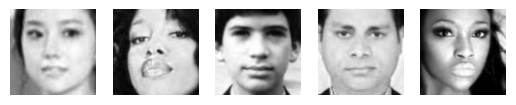

In [13]:
normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    normalize_transform
])

val_test_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    normalize_transform
])

train_dataset = UTKFaceDataset(train_df, transform=train_transforms)
val_dataset = UTKFaceDataset(val_df, transform=val_test_transforms)
test_dataset = UTKFaceDataset(test_df, transform=val_test_transforms)

num_workers = 2
if platform.system() == "Windows":
    num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True if DEVICE.type == 'cuda' else False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True if DEVICE.type == 'cuda' else False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True if DEVICE.type == 'cuda' else False)

# Display some augmented training images
print("\nDisplaying some augmented training images:")
IMG_TO_DISPLAY = 5
x_batch_disp, y_batch_disp = next(iter(train_loader))

def imshow(imges):
    plt.figure()
    for i in range(IMG_TO_DISPLAY):
        img = imges[i,0]
        img = img / 2 + 0.5 #unnormalize
        npimg = img.numpy()
        plt.subplot(1,IMG_TO_DISPLAY,i+1)
        plt.imshow(npimg, cmap='gray')
        plt.axis('off')
    plt.show

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(images)
print('Classes are: ')
print('| '.join(f'{class_names_list[labels[j]]:5s} ' for j in range(IMG_TO_DISPLAY)))

In [14]:
# Pre-trained ResNet50 from torchvision
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
# CCT
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, NUM_CLASSES)
)
model = model.to(DEVICE)
print(model.fc)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jupyter/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100% 97.8M/97.8M [00:00<00:00, 143MB/s] 


Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=256, out_features=4, bias=True)
)


In [15]:
MODEL_SAVE_DIR = "saved_models_pytorch" # Directory to save models

criterion = nn.CrossEntropyLoss()
optimizer_head = optim.Adam(model.fc.parameters(), lr=INITIAL_LEARNING_RATE)
scheduler_head = optim.lr_scheduler.ReduceLROnPlateau(optimizer_head, mode='min', factor=0.1, patience=3)

# --- Training and Validation Functions (PyTorch specific) ---
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)
    return running_loss / total_samples, (correct_predictions.double() / total_samples).item()

def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_preds_list = []
    all_labels_list = []
    all_probs_list = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
            all_preds_list.extend(preds.cpu().numpy())
            all_labels_list.extend(labels.cpu().numpy())
            all_probs_list.extend(torch.softmax(outputs, dim=1).cpu().numpy())
    return running_loss / total_samples, (correct_predictions.double() / total_samples).item(), all_labels_list, all_preds_list, all_probs_list

# Training Phase 1 Train the Head
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0
create_directory(MODEL_SAVE_DIR)
best_model_path_head = os.path.join(MODEL_SAVE_DIR, "resnet50_utkface_head_best_pytorch.pth")

print(f"\n--- Training the classification head for {INITIAL_EPOCHS} epochs ---")
training_start_time_total = time.time()
for epoch in range(INITIAL_EPOCHS):
    epoch_start_time = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer_head, DEVICE)
    val_loss, val_acc, _, _, _ = validate_model(model, val_loader, criterion, DEVICE)
    epoch_end_time = time.time()
    print(f"Epoch {epoch+1}/{INITIAL_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Time: {(epoch_end_time - epoch_start_time):.2f}s")
    history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
    scheduler_head.step(val_loss)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path_head)
        print(f"Epoch {epoch+1}: New best head model saved with Val Acc: {val_acc:.4f}")

model.load_state_dict(torch.load(best_model_path_head))


total_training_time = time.time() - training_start_time_total
print(f"Total training finished. Time: {total_training_time:.2f}s. Best Val Acc: {best_val_acc:.4f}")

Directory created: /home/jupyter/dlfp_age_task/saved_models_pytorch

--- Training the classification head for 15 epochs ---
Epoch 1/15 | Train Loss: 0.8433 | Train Acc: 0.6584 | Val Loss: 0.7219 | Val Acc: 0.7072 | Time: 59.27s
Epoch 1: New best head model saved with Val Acc: 0.7072
Epoch 2/15 | Train Loss: 0.7609 | Train Acc: 0.6999 | Val Loss: 0.7457 | Val Acc: 0.6872 | Time: 61.36s
Epoch 3/15 | Train Loss: 0.7282 | Train Acc: 0.7087 | Val Loss: 0.6818 | Val Acc: 0.7258 | Time: 60.61s
Epoch 3: New best head model saved with Val Acc: 0.7258
Epoch 4/15 | Train Loss: 0.7187 | Train Acc: 0.7148 | Val Loss: 0.6806 | Val Acc: 0.7244 | Time: 60.94s
Epoch 5/15 | Train Loss: 0.7050 | Train Acc: 0.7167 | Val Loss: 0.6773 | Val Acc: 0.7293 | Time: 61.03s
Epoch 5: New best head model saved with Val Acc: 0.7293
Epoch 6/15 | Train Loss: 0.7053 | Train Acc: 0.7189 | Val Loss: 0.6674 | Val Acc: 0.7381 | Time: 61.12s
Epoch 6: New best head model saved with Val Acc: 0.7381
Epoch 7/15 | Train Loss: 0.6


Loading best model from saved_models_pytorch/resnet50_utkface_head_best_pytorch.pth for final evaluation.


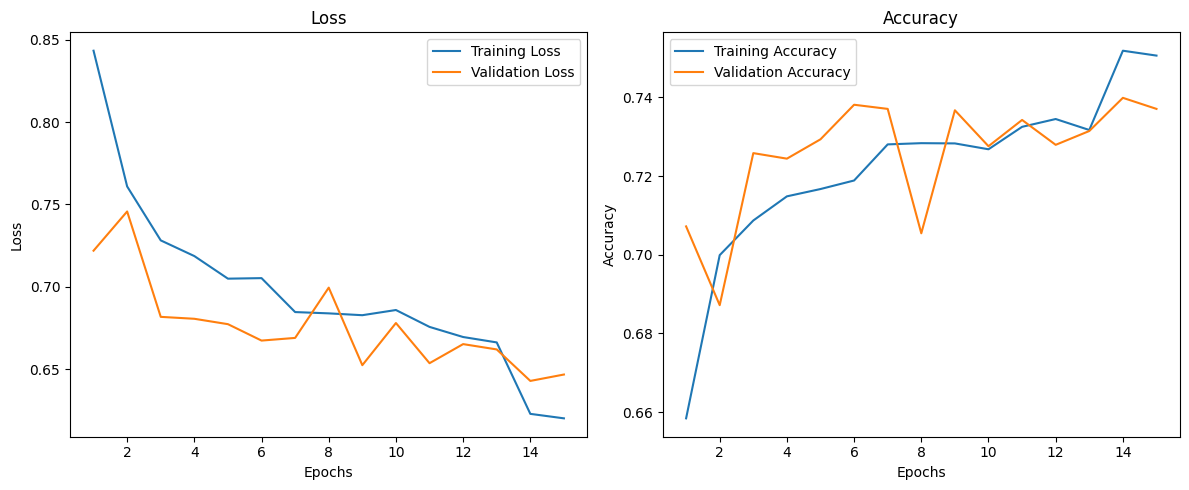


Evaluating on Test Set...
Test Loss: 0.6288
Test Accuracy (Overall): 0.7474

Confusion Matrix on Test Set:


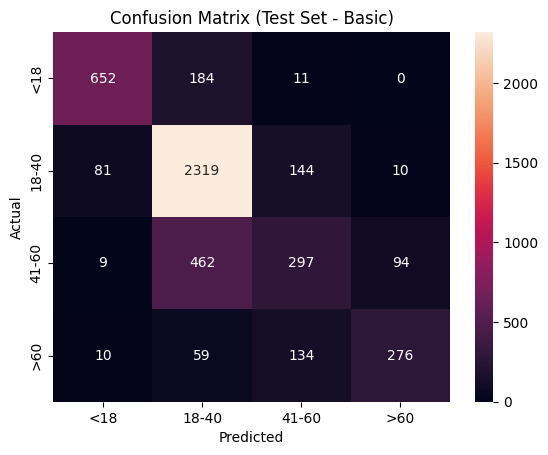


Classification Report:
              precision    recall  f1-score   support

         <18     0.8670    0.7698    0.8155       847
       18-40     0.7669    0.9080    0.8315      2554
       41-60     0.5068    0.3445    0.4102       862
         >60     0.7263    0.5762    0.6426       479

    accuracy                         0.7474      4742
   macro avg     0.7168    0.6496    0.6750      4742
weighted avg     0.7334    0.7474    0.7330      4742


Example predictions with confidence scores (from test set):
Sample 1:
  True Age Class: 18-40
  Predicted Age Class: 18-40 (Confidence: 0.9814)
  All Class Confidences: ['0.003', '0.981', '0.016', '0.000']
Sample 2:
  True Age Class: 18-40
  Predicted Age Class: 18-40 (Confidence: 0.8641)
  All Class Confidences: ['0.063', '0.864', '0.070', '0.003']
Sample 3:
  True Age Class: 41-60
  Predicted Age Class: 18-40 (Confidence: 0.7174)
  All Class Confidences: ['0.089', '0.717', '0.169', '0.025']
Sample 4:
  True Age Class: 41-60
  Predic

In [16]:
# Evaluate Results Properly
print(f"\nLoading best model from {best_model_path_head} for final evaluation.")
model.load_state_dict(torch.load(best_model_path_head))

# Loss and Accuracy Plots
epochs_range_total = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_total, history['train_loss'], label='Training Loss')
plt.plot(epochs_range_total, history['val_loss'], label='Validation Loss')
if INITIAL_EPOCHS < len(history['train_loss']): plt.axvline(x=INITIAL_EPOCHS, color='gray', linestyle='--', label='Start Fine-tuning')
plt.legend(); plt.title('Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(epochs_range_total, history['train_acc'], label='Training Accuracy')
plt.plot(epochs_range_total, history['val_acc'], label='Validation Accuracy')
if INITIAL_EPOCHS < len(history['train_acc']): plt.axvline(x=INITIAL_EPOCHS, color='gray', linestyle='--', label='Start Fine-tuning')
plt.legend(); plt.title('Accuracy'); plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.tight_layout(); plt.show()

# Evaluate on Test Set
print("\nEvaluating on Test Set...")
test_loss, test_accuracy, y_true_test, y_pred_test, y_probs_test = validate_model(model, test_loader, criterion, DEVICE)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy (Overall): {test_accuracy:.4f}")

# Confusion Matrix
print("\nConfusion Matrix on Test Set:")
cm = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names_list, yticklabels=class_names_list)
plt.title("Confusion Matrix (Test Set - Basic)"); plt.ylabel('Actual'); plt.xlabel('Predicted'); plt.show()


print("\nClassification Report:")
print(classification_report(y_true_test, y_pred_test, target_names=class_names_list, digits=4))

# Confidence Scores
print("\nExample predictions with confidence scores (from test set):")
for i in range(min(5, len(y_true_test))): # Show first 5 examples
    true_label = class_names_list[y_true_test[i]]
    pred_label = class_names_list[y_pred_test[i]]
    # y_probs_test has the softmax probabilities for each class for each test sample
    confidence_pred_class = y_probs_test[i][y_pred_test[i]]
    all_class_confidences = y_probs_test[i]

    print(f"Sample {i+1}:")
    print(f"  True Age Class: {true_label}")
    print(f"  Predicted Age Class: {pred_label} (Confidence: {confidence_pred_class:.4f})")
    print(f"  All Class Confidences: {[f'{c:.3f}' for c in all_class_confidences]}")


# Time and Resource Consumption
print(f"\nTotal Training Time (Head + Fine-tune): {total_training_time:.2f} seconds")

# Inference time for one batch
model.eval()
dummy_input_batch = next(iter(test_loader))[0].to(DEVICE) # Get one batch of test data
inf_start_time = time.time()
with torch.no_grad():
    _ = model(dummy_input_batch)
inf_end_time = time.time()
avg_inference_time_per_batch = (inf_end_time - inf_start_time)
avg_inference_time_per_image = avg_inference_time_per_batch / BATCH_SIZE
print(f"Average inference time per batch ({BATCH_SIZE} images): {avg_inference_time_per_batch:.4f} seconds")
print(f"Average inference time per image: {avg_inference_time_per_image:.6f} seconds")
print("Resource Consumption: Monitor GPU/CPU utilization and memory manually (e.g., nvidia-smi or htop).")
